In [1]:
from pathlib import Path

In [2]:
import sys
sys.path.append("/home/kl5675/Documents/22/git_sync/hpo/scripts")

In [3]:
from tune_02_perfect_ec import DynamicTCNTrainable

/scratch/gpfs/kl5675/miniconda3/envs/gnn/lib/python3.10/site-packages/wandb_osh/ray_hooks.py:7: DeprecationWarning: The module `ray.tune.trial` has been moved to `ray.tune.experiment.trial` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.trial` with `ray.tune.experiment.trial`.
  from ray.tune.trial import Trial


In [4]:
# ray_dir = Path("~").expanduser() / "ray_results"
# assert ray_dir.is_dir()

# group_name = "tcn-perfect"

# ray_group_dir = ray_dir / group_name
# assert ray_group_dir.is_dir()

# experiment_name = "DynamicTCNTrainable_44ec0e7e_11_attr_pt_thld=0.5522,batch_size=1,gnn_tracking_experiments_hash=ef12903a6f862a36bedcd8b90da61ad0d39_2022-12-02_11-32-43"

In [5]:
checkpoint_path = Path("/home/kl5675/ray_results/tcn-perfect/DynamicTCNTrainable_d57969c8_3_attr_pt_thld=0.8358,batch_size=1,gnn_tracking_experiments_hash=ef12903a6f862a36bedcd8b90da61ad0d394_2022-12-02_10-56-07/checkpoint_000029/checkpoint.pt")
assert checkpoint_path.is_file()

In [6]:
params_file = checkpoint_path.parent.parent / "params.json"
assert params_file.is_file()

In [7]:
import json

In [8]:
config = json.loads(params_file.read_text())

In [9]:
config.update({"n_graphs_train": 1, "n_graphs_val": 100, "n_graphs_test": 1})

In [10]:
trainable = DynamicTCNTrainable(config)

DEBUG: Got config
{'attr_pt_thld': 0.8357702532381952,
 'batch_size': 1,
 'gnn_tracking_experiments_hash': 'ef12903a6f862a36bedcd8b90da61ad0d3943880',
 'gnn_tracking_hash': 'da818f30b45baf7a38c87a9815a775c26b0afc79',
 'lr': 0.0003246027846492765,
 'm_L_hc': 3,
 'm_alpha_hc': 0.32851561405194457,
 'm_e_dim': 4,
 'm_ec_tnr': 1.0,
 'm_ec_tpr': 1.0,
 'm_h_dim': 8,
 'm_h_outdim': 3,
 'm_hidden_dim': 116,
 'n_graphs_test': 1,
 'n_graphs_train': 1,
 'n_graphs_val': 100,
 'optimizer': 'adam',
 'q_min': 0.3603763762784664,
 'rlw_background': 1.0,
 'rlw_potential_attractive': 1.0,
 'rlw_potential_repulsive': 2.5588123653877557,
 'sb': 0.1254299622946947,
 'scheduler': None,
 'test': False}
INFO: Loading data to cpu memory
INFO: Loading 102 graphs (out of 3200 available).
DEBUG: Parameters for data loaders: {'batch_size': 1, 'num_workers': 12}
/scratch/gpfs/kl5675/miniconda3/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worke

In [11]:
trainable.load_checkpoint(checkpoint_path, device="cpu")

In [12]:
import torch

In [13]:
trainer = trainable.trainer
trainer.model.eval()

with torch.no_grad():
    loader = trainer.val_loader
    
    data = list(loader)[50].to(trainer.device)
    model_output = trainer.evaluate_model(data, mask_pids_reco=False)


In [14]:
model_output["x"].shape

torch.Size([2638, 3])

In [15]:
model_output["x"][:, :2].shape

torch.Size([2638, 2])

In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [118]:
def plot_all_coordinates(x: np.ndarray, ax=None):
    if x.shape[1] < 2 or x.shape[1] > 3:
        raise ValueError("This plot function only works for latent space dimension 2 or 3")
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    c = None
    if x.shape[1] == 3:
        c = x[:, 2]
    cax = ax.scatter(x[:, 0], x[:, 1], c=c, s=2)
    fig.colorbar(cax)
    if x.shape[1] == 3:
        ax.set_title("Color is third dimension")

In [133]:
def plot_all_coordinates_3d(x: np.ndarray, pid: np.ndarray, ax=None):
    if not x.shape[1] == 3:
        raise ValueError("This plot function only works for latent space dimension  3")
    if ax is None:
        ax = plt.figure().add_subplot(projection='3d')
    noise_mask = pid <= 0
    nnx = x[~noise_mask]
    ax.scatter3D(nnx[:, 0], nnx[:, 1], nnx[:, 2], s=2, c=pid[~noise_mask])
    nx = x[noise_mask]
    ax.scatter3D(nx[:, 0], nx[:, 1], nx[:, 2], s=2, c="red")

<IPython.core.display.Javascript object>


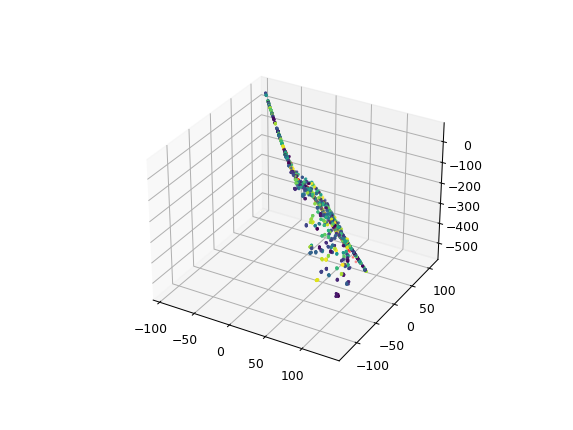

In [134]:
plot_all_coordinates_3d(x, pid)

In [113]:
x = model_output["x"]
pid = model_output["particle_id"]
pt = model_output["pt"]

<IPython.core.display.Javascript object>


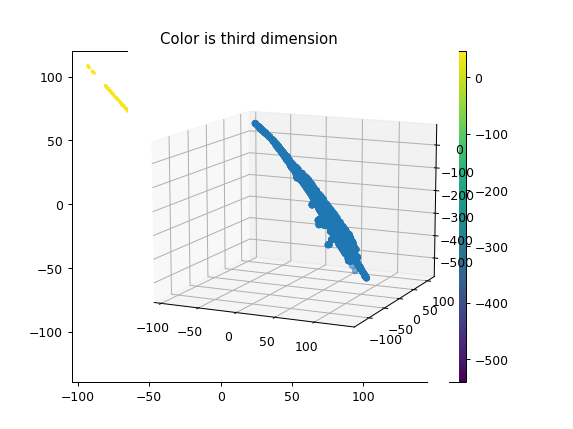

In [114]:
plot_all_coordinates(x)

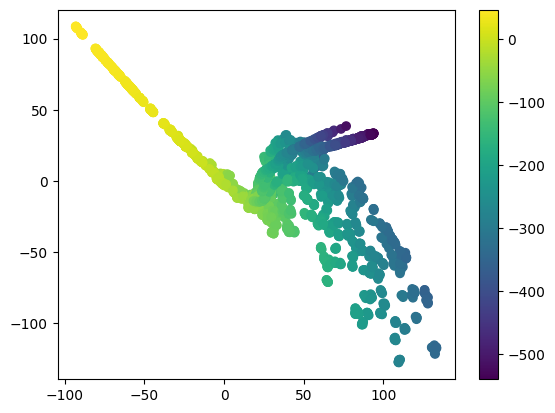

In [51]:
plot_all_coordinates(x)

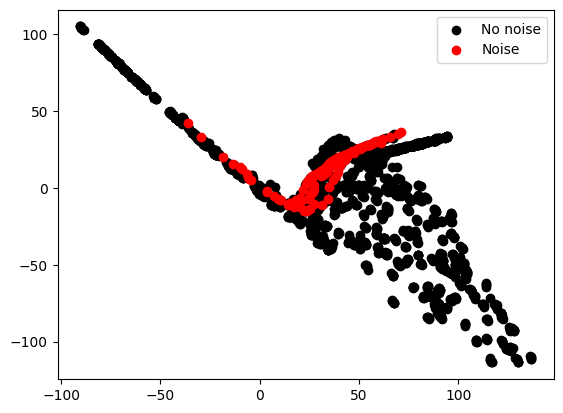

In [21]:
plt.scatter(x[pid > 0][:, 0], x[pid > 0][:, 1], c="black", label="No noise")
plt.scatter(x[pid <= 0][:, 0], x[pid <= 0][:, 1], c="red", label="Noise")
plt.legend()

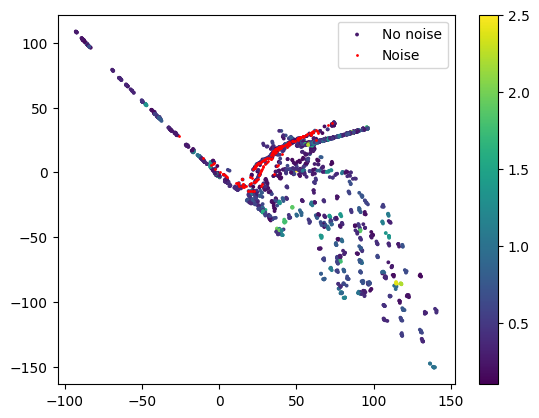

In [93]:
cax = plt.scatter(x[pid > 0][:, 0], x[pid > 0][:, 1], c=pt[pid > 0], label="No noise", s=3)
plt.scatter(x[pid <= 0][:, 0], x[pid <= 0][:, 1], c="red", label="Noise", s=1)
plt.colorbar(cax)
plt.legend()

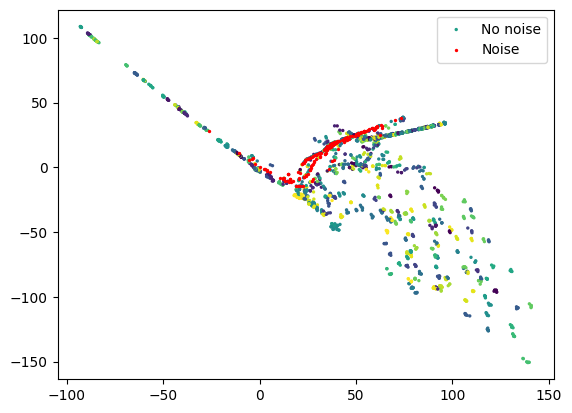

In [97]:
cax = plt.scatter(x[pid > 0][:, 0], x[pid > 0][:, 1], c=pid[pid > 0], label="No noise", s=2)
plt.scatter(x[pid <= 0][:, 0], x[pid <= 0][:, 1], c="red", label="Noise", s=2)
plt.legend()

In [30]:
import pandas as pd
_, c = np.unique(selected_pids, return_inverse=True)

In [33]:
len(selected_pids)

15

In [32]:
len(c)

15

In [49]:
%matplotlib notebook

In [87]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [105]:
def draw_circles(ax: plt.Axes, xs: np.ndarray, ys: np.ndarray, colors, eps=1):
    assert xs.shape == ys.shape
    for x, y, c in zip(xs, ys, colors):
#         circle = plt.Circle((x, y), eps, edgecolor=c, linestyle="-", )
        circle = plt.Circle((x, y), eps, facecolor=lighten_color(c, 0.2), linestyle="none")
        ax.add_patch(circle)

<IPython.core.display.Javascript object>


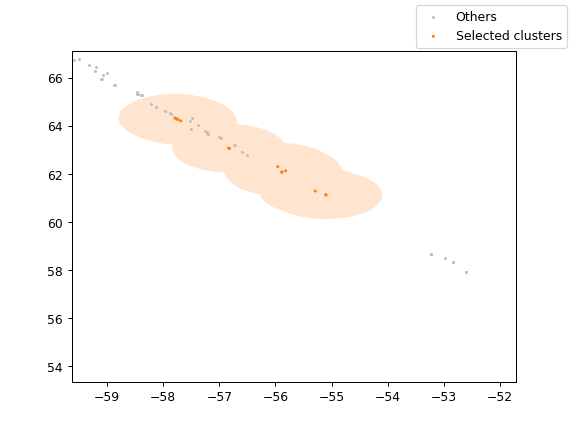

<IPython.core.display.Javascript object>


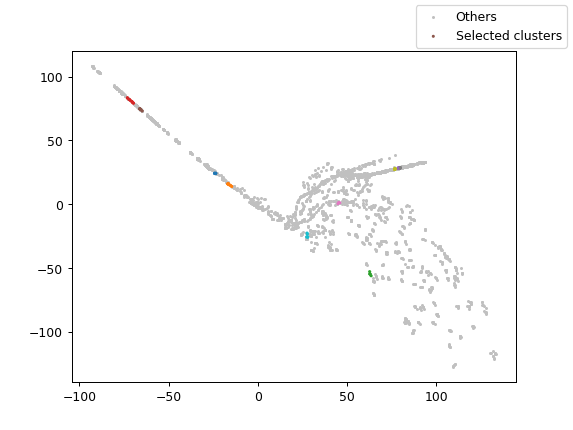

<IPython.core.display.Javascript object>


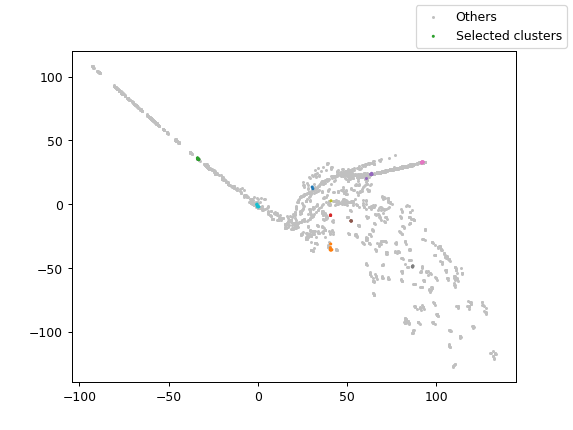

<IPython.core.display.Javascript object>


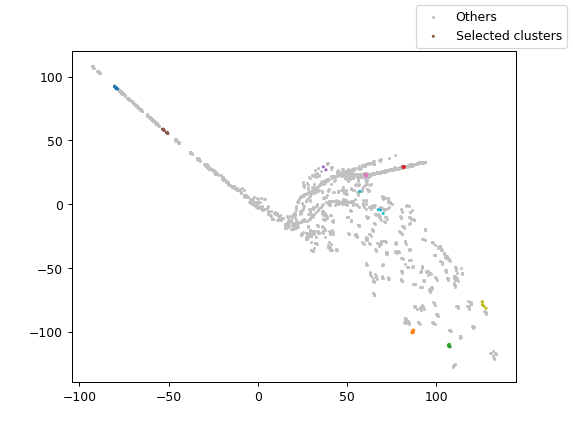

<IPython.core.display.Javascript object>


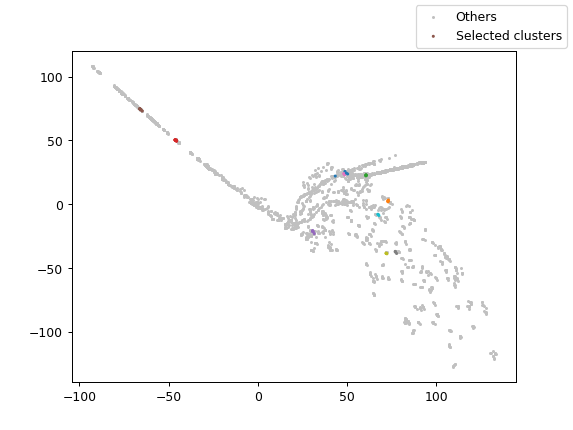

In [110]:
# todo: mark condensation point
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_mapper = np.vectorize(colors.__getitem__)
for i in range(5):
    selected_pids = np.random.choice(pid[pid > 0], 10).astype("int64")
    # map PIDs to number 0 to #PIDs - 1
    pid_mapper = np.vectorize({p.item(): i for i, p in enumerate(selected_pids)}.get)
    mask = np.isin(pid, selected_pids)
    fig, ax = plt.subplots()
    
    c = color_mapper(pid_mapper(pid[mask]))
    draw_circles(ax , x[mask][:, 0], x[mask][:, 1], c)
    ax.scatter(x[~mask][:, 0], x[~mask][:, 1], c="silver", alpha=1, label="Other hits", s=2)
    cax = ax.scatter( x[mask][:, 0], x[mask][:, 1], c=c, label="Hits of selected PIDs", s=2)
    fig.legend()